In [2]:
import mosek
import numpy as np
from itertools import permutations
from math import sqrt,log,factorial,floor
import random 
import time
#from sympy import Matrix
import seaborn as sns
import pandas as pd

In [11]:
def FrobeniusNorm(diff):
    Fnorm=0
    for t in range(int(n*(n-1))):
        Fnorm+=(diff[t])**2
    return sqrt(Fnorm)

def entropy(xx):
    ent=0
    negative=0
    zero=0
    for i in range(T):
        if xx[i]<0:
            negative+=1
            continue
        if xx[i]==0:
            zero+=1
            continue
        ent-=xx[i]*log(xx[i])
        
    print('the number of negative values: ',negative,'; the number of 0: ',zero)
    return ent

def assess(xx):
    xx=np.reshape(xx,(T,1))
    diff=np.dot(A,xx)-b
    return FrobeniusNorm(diff)/(n*(n-1)), entropy(xx)

def report(xx,u,status,runtime):
    """
    yy=xx[u:u+T]
    yy.sort(reverse=True)
    print('Sorted probabilities:\n',yy)
    """
    xxx=np.zeros((T))
    count=0
    for t in range(T):
        if xx[t] > 10**(-5):
            xxx[t]=xx[t]
            count+=1
    #print('the number of rank is:',count)
    print('the status is:',status)
    print('the runtime is:',runtime)
    print('the size of the orderings set is',T)

def msk_relent(task, t, x, y):
    v = msk_newvar(task, 1)
    c = msk_newcon(task, 1)
    task.putaij(c, v, 1.0)
    task.putaij(c, t, 1.0)
    task.putconbound(c, mosek.boundkey.fx, 0.0, 0.0)
    task.appendcone(mosek.conetype.pexp, 0.0, [y, x, v])

def msk_newvar(task, num):  # free
    v = task.getnumvar()
    task.appendvars(num)
    for i in range(num):
        task.putvarbound(v+i, mosek.boundkey.fr, -inf, inf)
    return v

def msk_newvar_fx(task, num, val):  # fixed
    v = task.getnumvar()
    task.appendvars(num)
    for i in range(num):
        task.putvarbound(v+i, mosek.boundkey.fx, val, val)
    return v

def msk_newcon(task, num):
    c = task.getnumcon()
    task.appendcons(num)
    return c

def msk_sq(task, t, x): # t >= x^2
    task.appendcone(mosek.conetype.rquad, 0.0, [msk_newvar_fx(task, 1, 0.5), t, x])

def RPmatrix(n,distRD):
    count=0
    for p in permutations([*range(n)]):
        x_tem=np.array([1 if p[i]<p[j] else 0 for i in range(1,n) for j in range(i)]).reshape((int(n*(n-1)/2),1))
        y_tem=(x_tem==0).astype(int)
        z_tem=np.concatenate((x_tem,y_tem),axis=0)
        if count==0:
            A=z_tem
        else:
            A=np.concatenate((A,z_tem),axis=1)
        count+=1
    b=np.dot(A,distRD).reshape((int(n*(n-1)),1))
    return [A,b]

In [221]:
inf=100
df=pd.DataFrame(columns=['runtime','RP_error','entropy','met','n','m_divider'],index=[*range(4)])
rows=0

for repeat in range(3):
    for n in range(5,9):
        print('n: ',n)
        T=factorial(n)
        start=1
        distRD=np.zeros((T,1))
        for i in range(T-1):
            distRD[i]=[random.uniform(0,start)]
            start=1-sum(distRD)
            if start < 0.01:
                break
        distRD[T-1]=[start]

        A,b=RPmatrix(n,distRD)

        df.loc[rows,:]=[0]+list(assess(distRD))+['RD']+[n,0]
        rows+=1
        if n<=8:
            df.loc[rows,:]=mev_ori()+['original']+[n,1]
            rows+=1
        val=sorted(range(T),key=lambda k: distRD[k],reverse=True) # rank of each ordering in RD measure
        for m_index in range(3,6):
        #m: the number of ordering selected
            m=int(T*m_index*0.1)
            if m <= T:
                incl_tem=set([*range(1,T+1)]*(np.array(val)<m))-set([0])
                incl=[ignore-1 for ignore in incl_tem]
                nincl=[x for x in range(T) if x not in incl]
                val2=np.sum(A[:,nincl]>0,axis=1)>0 # true: \sum t_i \leq S_{i,j} 
                print(sum(val2)/(n*(n-1)))
                df.loc[rows,:]=mev_relax(m)+['relax']+[n,0.1*m_index]
                rows+=1
            else:
                break
            
df=df.astype({'runtime': 'float32','RP_error': 'float32','entropy': 'float32','n': 'float32','m_divider':'float32'})

n:  5
the number of negative values:  0 ; the number of 0:  115
1 solsta.optimal
the number of negative values:  0 ; the number of 0:  0
1.0
0.3   solsta.optimal
the number of negative values:  0 ; the number of 0:  84
1.0
0.4   solsta.optimal
the number of negative values:  0 ; the number of 0:  72
1.0
0.5   solsta.optimal
the number of negative values:  0 ; the number of 0:  60
n:  6
the number of negative values:  0 ; the number of 0:  715
1 solsta.optimal
the number of negative values:  0 ; the number of 0:  0
1.0
0.3   solsta.optimal
the number of negative values:  0 ; the number of 0:  504
1.0
0.4   solsta.optimal
the number of negative values:  0 ; the number of 0:  432
1.0
0.5   solsta.optimal
the number of negative values:  0 ; the number of 0:  360
n:  7
the number of negative values:  0 ; the number of 0:  5034
1 solsta.optimal
the number of negative values:  0 ; the number of 0:  0
1.0
0.3   solsta.optimal
the number of negative values:  0 ; the number of 0:  3528
1.0
0.4  

In [229]:
#df.to_csv('mev_measure.csv',index=None)

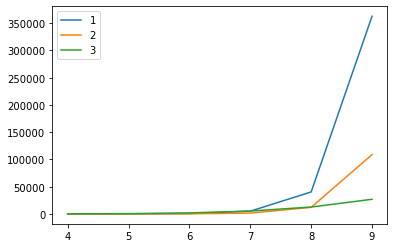

In [197]:
fact=[]
rela=[]
rela2=[]
for test in range(4,10):
    fact+=[factorial(test)]
    rela+=[(factorial(test))*0.3]
    rela2+=[log(factorial(test))**4]

plt.plot(range(4,10),fact,label='1')
plt.plot(range(4,10),rela,label='2')
plt.plot(range(4,10),rela2,label='3')
plt.legend()

In [12]:
def mev_relax(m):
    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------

    u = msk_newvar(task, m)
    eta = msk_newvar(task, m)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(m):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+m),[1.0]*m)
    task.putconbound(c, mosek.boundkey.fx, 1, 1.0)    

    # max entropy
    for i in range(m):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical if false
    # u*theoretical<=empirical if true
    k=0
    #for key,val in constraint_sign.items():
    for k in range(int(n*(n-1))):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+m),A[k,incl])
        task.putconbound(c, mosek.boundkey.fx, b[k],b[k])
        #if val[k]:
        #    task.putconbound(c, mosek.boundkey.ra, 0,b[k])   
        #else:
        #    task.putconbound(c, mosek.boundkey.fx, b[k],b[k])
        k+=1

    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+m),[1]*m)

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)

    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()
    
    print(m/T,' ',task.getsolsta(mosek.soltype.itr))
    
    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    xx_recover=[0]*T
    j=0
    for i in incl:
        xx_recover[i]=xx[j]
        j+=1
    norm,ent=assess(xx_recover)
    return [endtime-starttime, norm,ent]

In [12]:
def mev_relax(m):
    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------

    u = msk_newvar(task, m)
    eta = msk_newvar(task, m)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(m):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+m),[1.0]*m)
    task.putconbound(c, mosek.boundkey.fx, 1, 1.0)    

    # max entropy
    for i in range(m):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical if false
    # u*theoretical<=empirical if true
    k=0
    #for key,val in constraint_sign.items():
    for k in range(int(n*(n-1))):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+m),A[k,incl])
        task.putconbound(c, mosek.boundkey.fx, b[k],b[k])
        #if val[k]:
        #    task.putconbound(c, mosek.boundkey.ra, 0,b[k])   
        #else:
        #    task.putconbound(c, mosek.boundkey.fx, b[k],b[k])
        k+=1

    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+m),[1]*m)

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)

    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()
    
    print(m/T,' ',task.getsolsta(mosek.soltype.itr))
    
    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    xx_recover=[0]*T
    j=0
    for i in incl:
        xx_recover[i]=xx[j]
        j+=1
    norm,ent=assess(xx_recover)
    return [endtime-starttime, norm,ent]

In [13]:
def mev_ori():
    ### MEV ==================================================================

    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    # t is the entropy of u
    u = msk_newvar(task, T)
    eta = msk_newvar(task, T)

    # constraints ------------------------------------------------------------

    # 0<u<1 
    for i in range(T):
        task.putvarbound(u+i, mosek.boundkey.ra, 0, 1)
        task.putvarbound(eta+i , mosek.boundkey.ra, -inf, 0)

    # sum(u)=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(u,u+T),[1.0]*T)
    task.putconbound(c, mosek.boundkey.fx, 1.0, 1.0)    

    # max entropy
    for i in range(T):
        msk_relent(task, eta+i, u+i, msk_newvar_fx(task, 1, 1.0)) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # u*theoretical=empirical
    for k in range(int(n*(n-1))):
        c = msk_newcon(task, 1)
        task.putarow(c, range(u, u+T),A[k,:])
        task.putconbound(c, mosek.boundkey.fx, b[k],b[k])

    # objective ----------------------------------------------------------------
    task.putclist(range(eta,eta+T),[1]*T)

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)

    # Solve the problem and print summary
    starttime = time.time()
    task.optimize()
    endtime = time.time()

    print('1',task.getsolsta(mosek.soltype.itr))
    
    # get solution of the diagonal (equal to the SDP var)
    xx = [0.0] * task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    #report(xx,u,task.getsolsta(mosek.soltype.itr),endtime-starttime)
    norm,ent=assess(xx[u:u+T])
    return [endtime-starttime, norm,ent]

# Plot

In [165]:
import matplotlib.pyplot as plt 

In [7]:
df=pd.read_csv('mev_measure.csv',header=0)

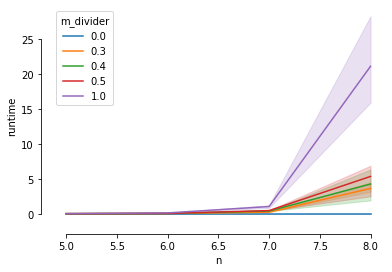

In [8]:
sns.lineplot(x="n", y="runtime",hue="m_divider",palette="tab10",#style="event", #palette=["m", "g",'y','r'],
            data=df[df["m_divider"]<10]) #df[df["m_divider"]!=3]
sns.despine(offset=10, trim=True)

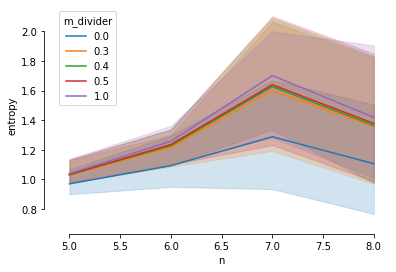

In [9]:
sns.lineplot(x="n", y="entropy",hue="m_divider",palette="tab10",#style="event",  #palette=["m", "g",'y','r'],
            data=df[df["m_divider"]<10]) #df[df["m_divider"]!=3]
sns.despine(offset=10, trim=True)

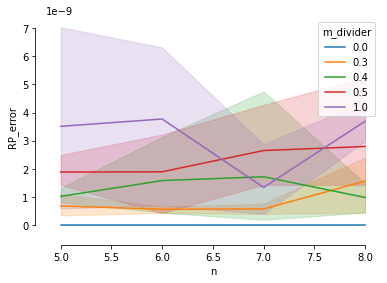

In [10]:
sns.lineplot(x="n", y="RP_error",hue="m_divider",palette="tab10",#style="event",  #palette=["m", "g",'y','r'],
            data=df[df["m_divider"]<100]) #df[df["m_divider"]!=3]
sns.despine(offset=10, trim=True)